In [2]:
# stolen from nvidia
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorboard.backend.event_processing.event_accumulator as event_accumulator


# Function to extract data from TensorBoard event files and convert to DataFrame
def tensorboard_to_dataframe(event_file):
    """Given a TensorBoard event file, return a pandas DataFrame with the training metrics."""
    # Load the event file
    ea = event_accumulator.EventAccumulator(
        event_file,
        size_guidance={
            event_accumulator.SCALARS: 0,  # 0 means load all
        },
    )
    ea.Reload()

    # Get list of all available tags
    tags = ea.Tags()["scalars"]

    # First, find the union of all steps
    all_steps = set()
    for tag in tags:
        events = ea.Scalars(tag)
        steps = [event.step for event in events]
        all_steps.update(steps)

    # Sort steps for proper ordering
    all_steps = sorted(all_steps)

    # Initialize the dataframe with steps
    df = pd.DataFrame({"step": all_steps})

    # Add each metric as a column
    for tag in tags:
        events = ea.Scalars(tag)
        # Create a dictionary mapping steps to values
        step_to_value = {event.step: event.value for event in events}
        # Add the values to the dataframe, using NaN for missing steps
        df[tag] = df["step"].map(step_to_value)

    return df


# Example of creating a multi-metric plot with seaborn
def plot_multiple_training_metrics(df, metrics_to_plot, figsize=(15, 10)):
    """Given a pandas DataFrame with the training metrics, plot the metrics."""
    n = len(metrics_to_plot)
    fig, axes = plt.subplots(n, 1, figsize=figsize, sharex=True)

    if n == 1:  # Handle the case of a single plot
        axes = [axes]

    sns.set_style("whitegrid")

    for i, metric in enumerate(metrics_to_plot):
        if metric in df.columns:
            sns.lineplot(x="step", y=metric, data=df, ax=axes[i], linewidth=2.5, errorbar="sd")
            axes[i].set_title(metric, fontsize=14)
            axes[i].set_ylabel("Value", fontsize=12)
    axes[-1].set_xlabel("Steps", fontsize=14)
    plt.tight_layout()
    plt.show()

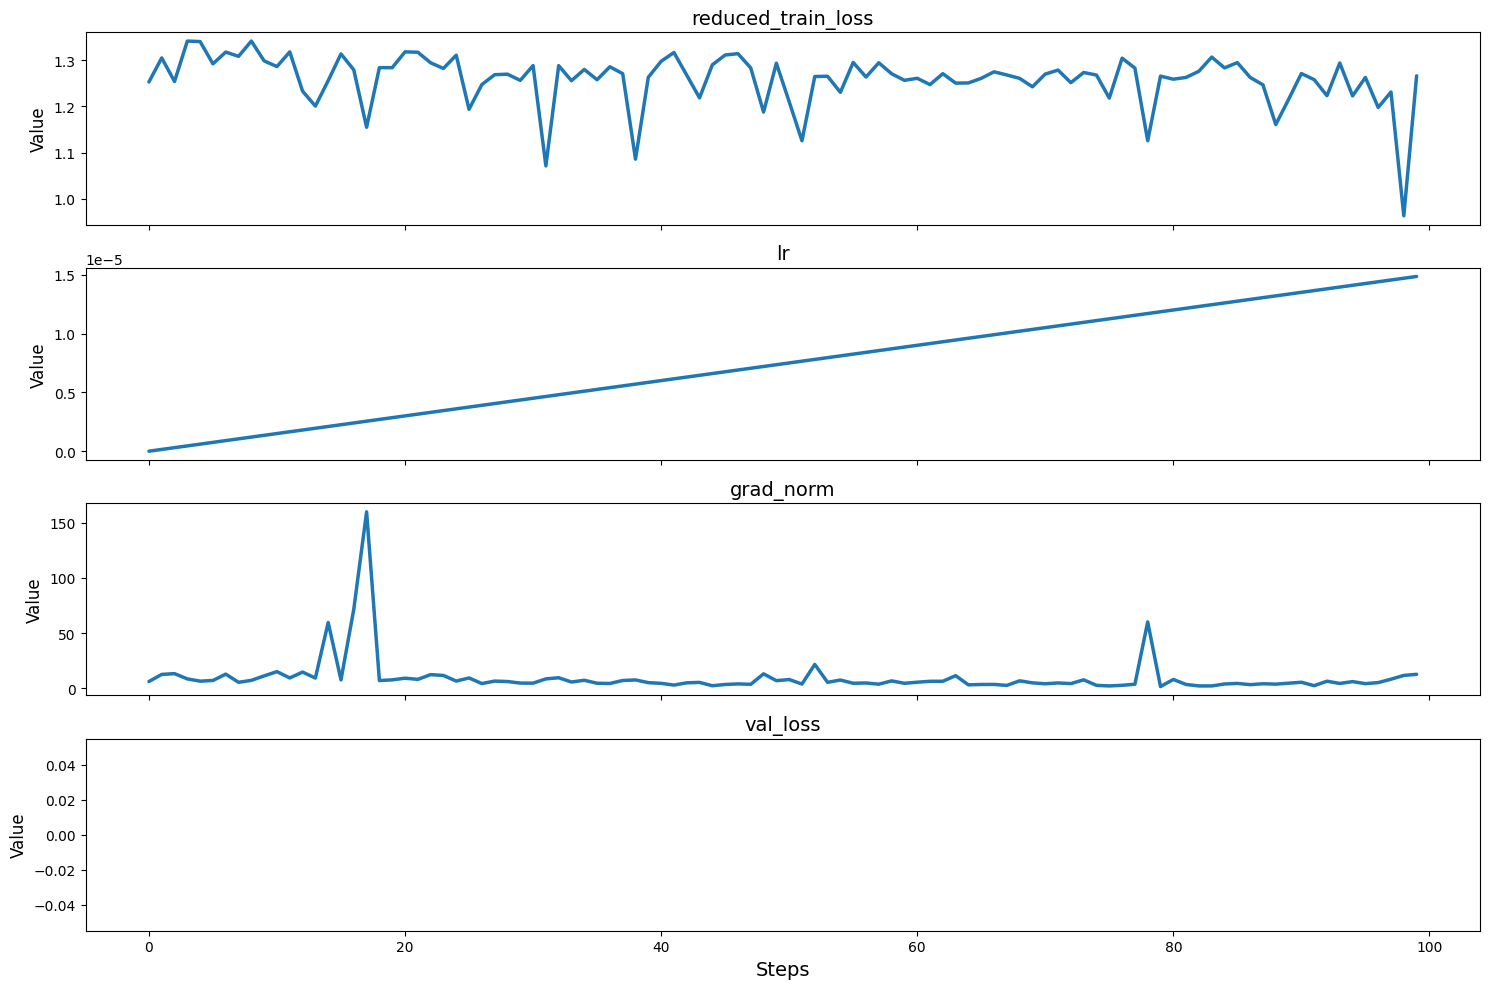

In [3]:
# Get the TensorBoard event file for the training run
log_dirs = !find pretraining_demo/evo2/dev -name "events.out.tfevents*"
tf_event_file = log_dirs[0]

# Extract data from your event file
df = tensorboard_to_dataframe(tf_event_file)
# You can uncomment and modify this to plot multiple metrics once you see what's available
plot_multiple_training_metrics(df, ["reduced_train_loss", "lr", "grad_norm", "val_loss"])

In [4]:
final_ckpt_paths = !ls -d pretraining_demo/evo2/checkpoints/*-last
final_ckpt_path = final_ckpt_paths[-1]
final_ckpt_path

'pretraining_demo/evo2/checkpoints/epoch=0-step=99-consumed_samples=800.0-last'